In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import lightgbm as lgb
from toolz import merge, curry
from econml.dml import LinearDML, DML


import warnings
warnings.filterwarnings("ignore")

In [36]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [37]:
df = pd.read_csv('bank-additional-full.csv', delimiter=';')

In [38]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


## Dataset Description: Bank Marketing

| Variable Name     | Role    | Type        | Demographic       | Description | Units | Missing Values |
|------------------|---------|-------------|-------------------|-------------|--------|----------------|
| age              | Feature | Integer     | Age               | age (numeric) |        | no             |
| job              | Feature | Categorical | Occupation        | type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown") |        | no             |
| marital          | Feature | Categorical | Marital Status    | marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed) |        | no             |
| education        | Feature | Categorical | Education Level   | (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown") |        | no             |
| default          | Feature | Categorical |                   | has credit in default? (categorical: "no","yes","unknown") |        | no             |
| housing          | Feature | Categorical |                   | has housing loan? (categorical: "no","yes","unknown") |        | no             |
| loan             | Feature | Categorical |                   | has personal loan? (categorical: "no","yes","unknown") |        | no             |
| contact          | Feature | Categorical |                   | contact communication type (categorical: "cellular","telephone") |        | no             |
| month            | Feature | Categorical |                   | last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec") |        | no             |
| day_of_week      | Feature | Categorical |                   | last contact day of the week (categorical: "mon","tue","wed","thu","fri") |        | no             |
| duration         | Feature | Integer     |                   | last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. | seconds | no             |
| campaign         | Feature | Integer     |                   | number of contacts performed during this campaign and for this client (numeric, includes last contact) |        | no             |
| pdays            | Feature | Integer     |                   | number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted) |        | no             |
| previous         | Feature | Integer     |                   | number of contacts performed before this campaign and for this client (numeric) |        | no             |
| poutcome         | Feature | Categorical |                   | outcome of the previous marketing campaign (categorical: "failure","nonexistent","success") |        | no             |
| emp.var.rate     | Feature | Float       |                   | employment variation rate - quarterly indicator (numeric) | percent | no             |
| cons.price.idx   | Feature | Float       |                   | consumer price index - monthly indicator (numeric) | index | no             |
| cons.conf.idx    | Feature | Float       |                   | consumer confidence index - monthly indicator (numeric) | index | no             |
| euribor3m        | Feature | Float       |                   | euribor 3 month rate - daily indicator (numeric) | rate | no             |
| nr.employed      | Feature | Float       |                   | number of employees - quarterly indicator (numeric) | persons | no             |
| y                | Target  | Binary      |                   | has the client subscribed a term deposit? (binary: "yes","no") |        | no             |


In [39]:
df.columns = df.columns.str.replace('.', '_', regex=False)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

In [41]:
df.describe()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


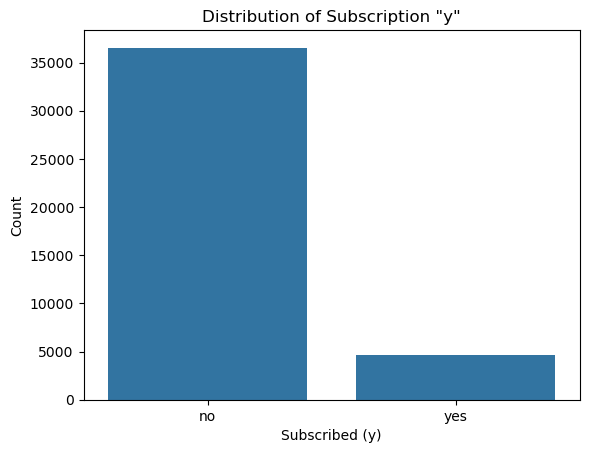

In [42]:
sns.countplot(x='y', data=df)
plt.title('Distribution of Subscription "y"')
plt.xlabel('Subscribed (y)')
plt.ylabel('Count')
plt.show()

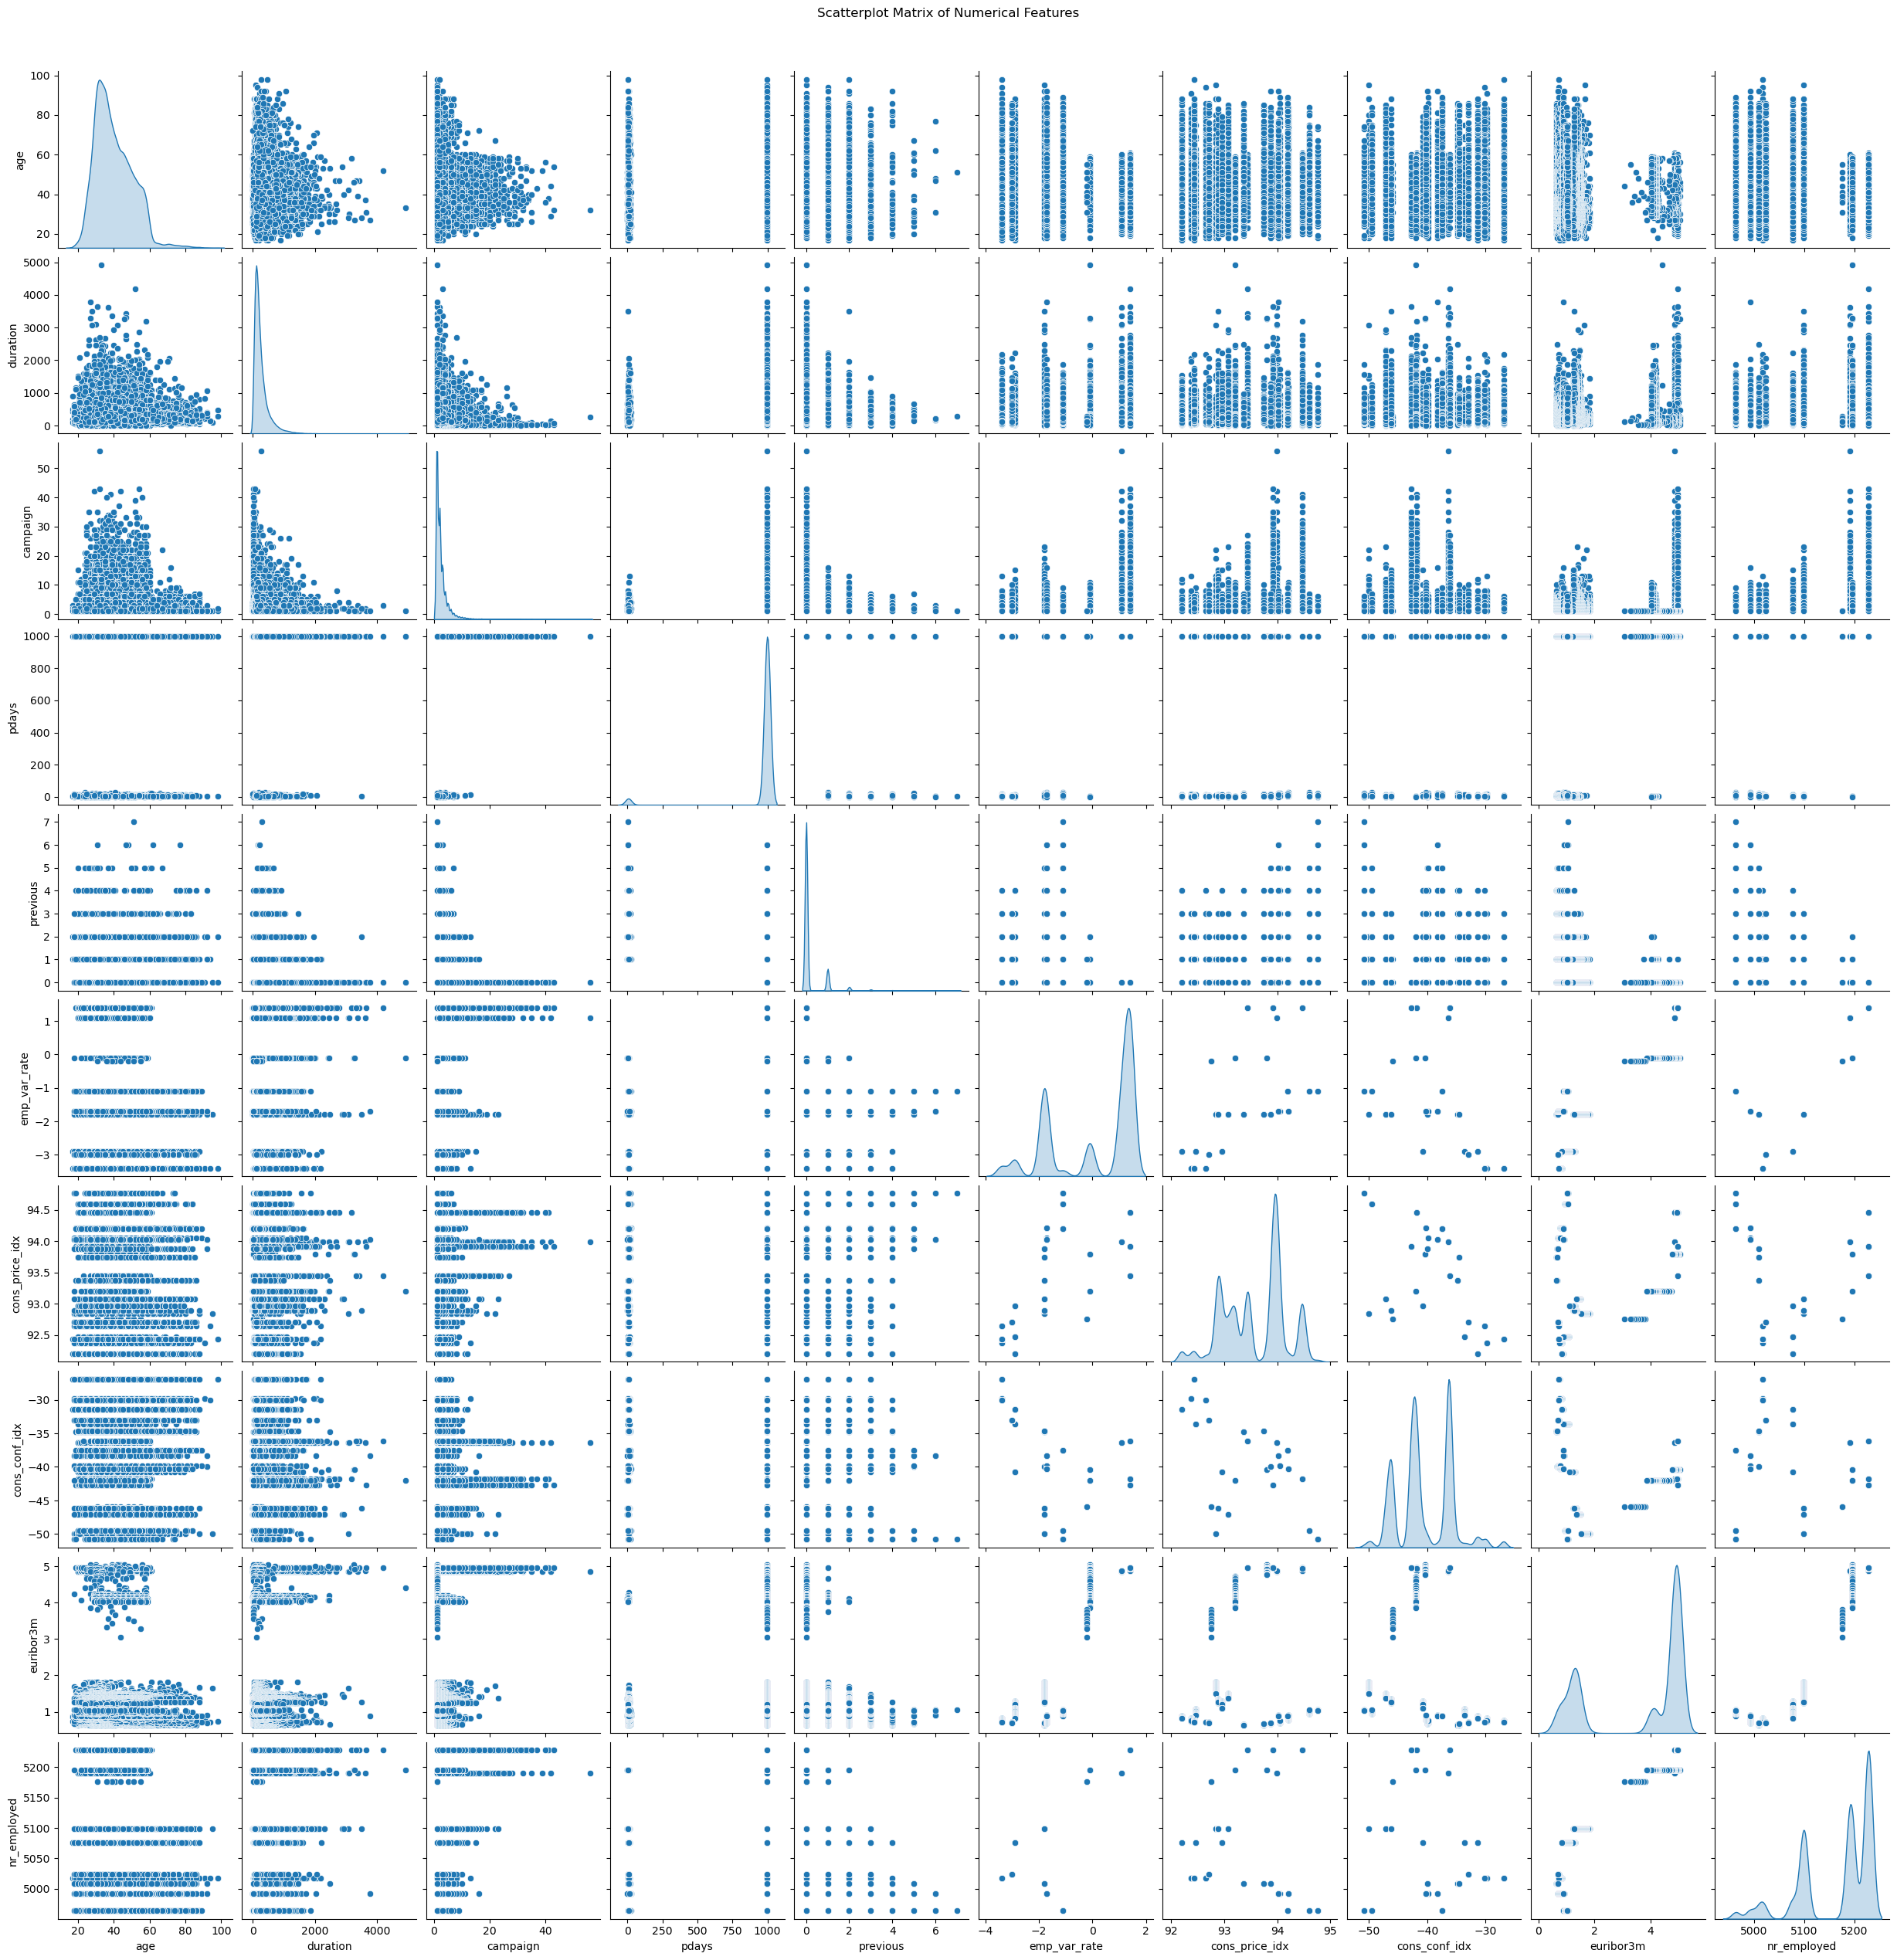

In [43]:
# Select only numerical columns
numeric_cols = df.select_dtypes(include='number')

# Create scatterplot matrix
sns.pairplot(numeric_cols, diag_kind='kde')  
plt.suptitle('Scatterplot Matrix of Numerical Features', y=1.02)
plt.show()

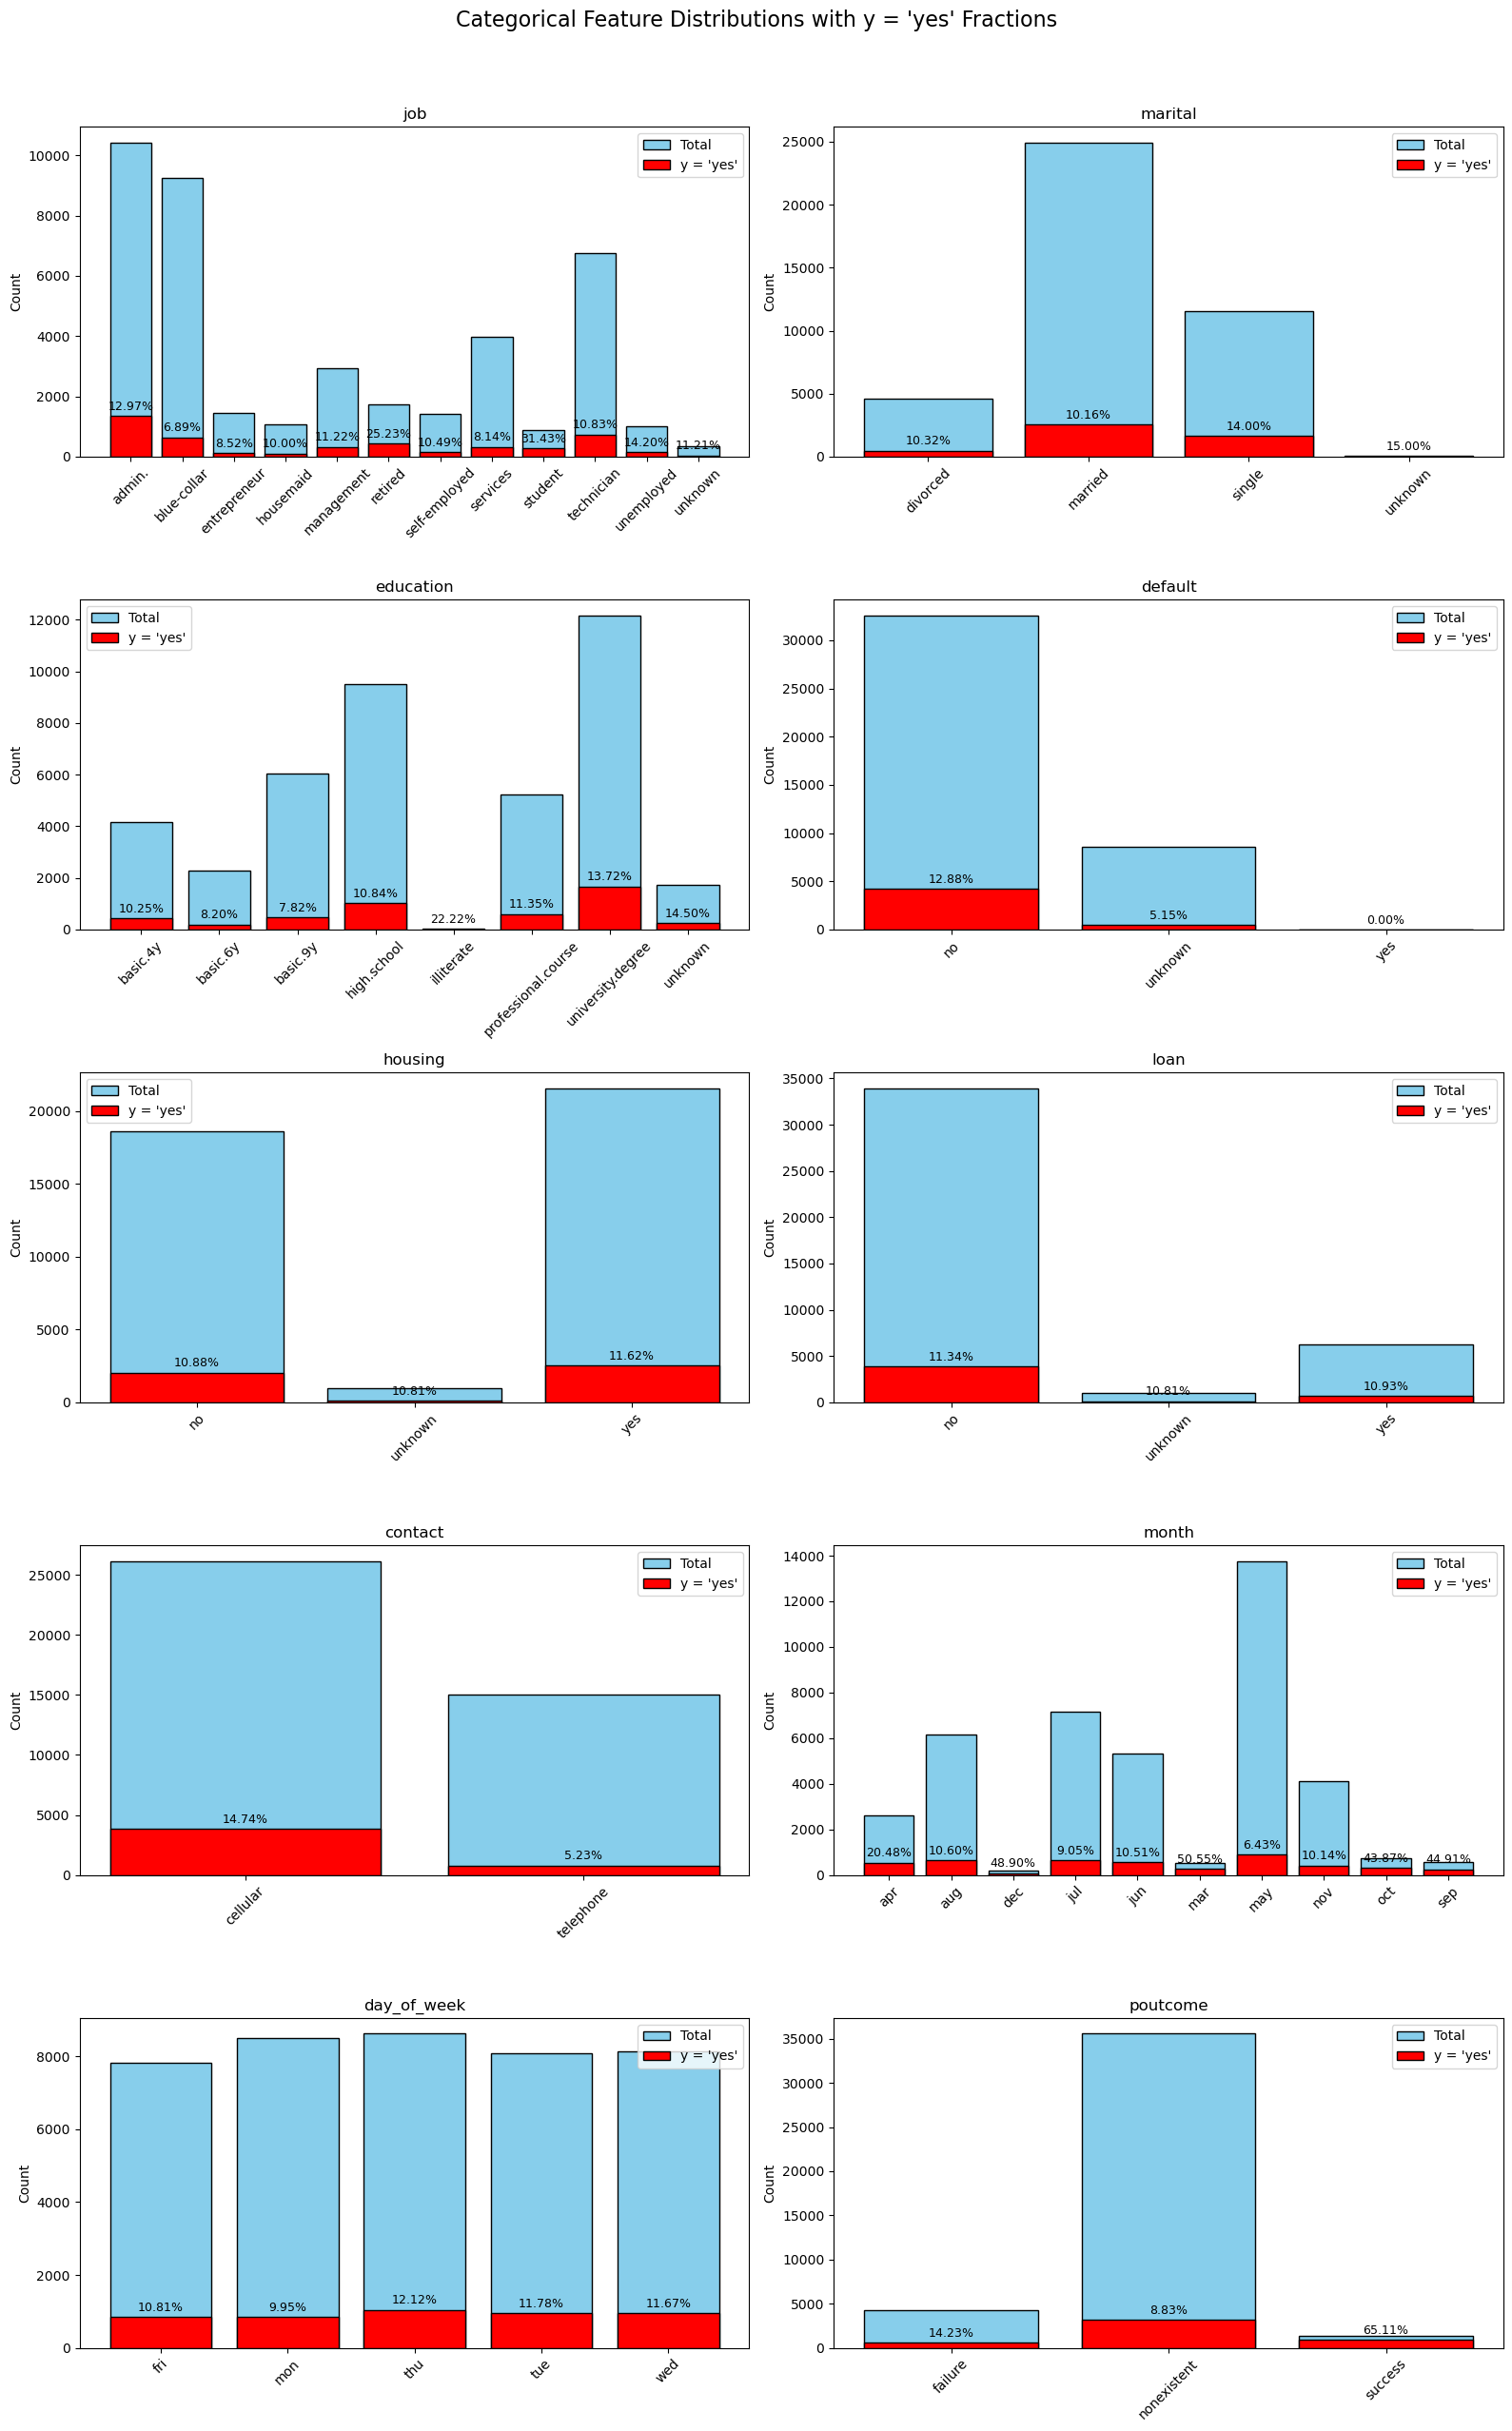

In [44]:
# Categorical features except the target
cat_features = df.select_dtypes(include='object').columns.tolist()
if 'y' in cat_features:
    cat_features.remove('y')


n_cols = 2
n_rows = (len(cat_features) + n_cols - 1) // n_cols
plt.figure(figsize=(n_cols * 8, n_rows * 5))

for i, col in enumerate(cat_features, 1):
    plt.subplot(n_rows, n_cols, i)

    # Count of y='yes' and y='no' per category
    count_data = df.groupby([col, 'y']).size().unstack().fillna(0)
    total = count_data.sum(axis=1)
    y_yes = count_data.get('yes', 0)
    y_frac = y_yes / total

    # Plot total bars
    plt.bar(total.index, total, color='skyblue', edgecolor='black', label='Total')

    # y='yes' bars
    plt.bar(y_yes.index, y_yes, color='red', edgecolor='black', label="y = 'yes'")

    # fraction labels
    for idx, (val, frac) in enumerate(zip(y_yes, y_frac)):
        plt.text(idx, val + total.max() * 0.01, f'{frac*100:.2f}%', ha='center', va='bottom', fontsize=9, color='black')

    plt.xticks(rotation=45)
    plt.title(f"{col}")
    plt.ylabel("Count")
    plt.legend()

plt.suptitle("Categorical Feature Distributions with y = 'yes' Fractions", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### Merging levels of ``default``

Since only three observations take ``yes``, and it does not provide additional information, I replace this level with ``unknown``. In other words, ``unknown`` is representative of true ``unknown`` and ``yes``.

In [45]:
df['default'].value_counts()

default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64

In [46]:
df['default'] = df['default'].replace('yes', 'unknown')

### Converting the type of variables

Since the outcome variable is logical, first, I convert it to a binary variable where it takes 1 if the customer subscribes (`yes`).

Also, to use logistic regression, I converted all variables of type ``object`` to ``category``.

In [47]:
df['y'] = df['y'].map({'no': 0, 'yes': 1})

for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')

In [48]:
df['y'].mean()

0.11265417111780131

## The Relationship Between Subscription Rate and The Number of Contacts

The figure shows that the average subscription rate declines as the number of campaign contacts increases. Clients contacted only once have the highest likelihood of subscribing, with the rate steadily decreasing as the number of contacts rises. This suggests that repeated follow-ups are less effective and may even reduce the chance of a positive response. The pattern highlights diminishing returns to persistence, implying that early contacts are more impactful, while continued outreach may target less interested individuals.

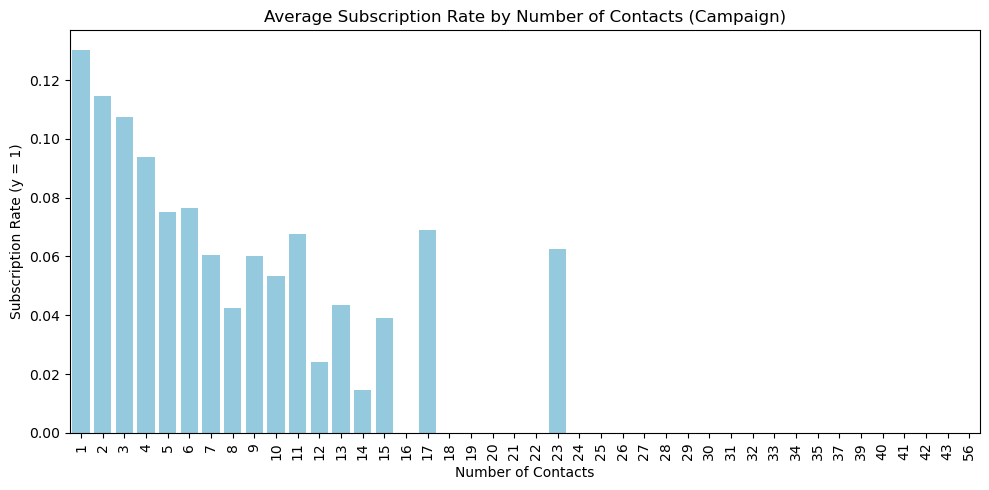

In [49]:
# Compute average subscription rate for each campaign level
grouped = df.groupby('campaign')['y'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=grouped, x='campaign', y='y', color='skyblue')
plt.title('Average Subscription Rate by Number of Contacts (Campaign)')
plt.xlabel('Number of Contacts')
plt.ylabel('Subscription Rate (y = 1)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# 1. Does increasing the number of contacts during a campaign (``campaign``) increase or decrease the likelihood of subscription?

This is an important question for banks because contacting a customer too many times might have negative effects. While more calls can increase the chance of success, it can also annoy customers and reduce trust in the brand. On the other hand, contacting too few times might miss opportunities to convert interested clients.

By understanding the causal effect of the number of contacts (``campaign``) on the final decision (``y``), banks can better plan their marketing strategy: they can reduce unnecessary costs, avoid over-contacting, and improve customer experience. This helps make campaigns more efficient and improves long-term customer relationships.

In this dataset, we are only observing clients who were **already contacted** by the bank.

The dataset **does not include**:

&emsp; &emsp;- Clients who were **eligible but never contacted**

&emsp; &emsp;- Clients **excluded** from campaigns due to risk profiles, history, or policies

This means:

&emsp; &emsp;We are conditioning on a **selected subpopulation**: "clients who were chosen for contact."

We are estimating the effect of ``campaign`` (number of contacts) **only among those who were contacted at all**.

&emsp; &emsp; - We're **not** estimating how effective ``campaign`` would be for clients who are never contacted.

&emsp; &emsp;- Here, our sample is **not random** from the population of all clients.
  
As a result, the effect we estimate is the **Average Treatment Effect on the Treated (ATT)**, not the population-wide ATE.  

This limitation arises due to **selection bias**: uncontacted clients are missing from the data, and we cannot account for how they would have responded.


In [50]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')

| Category               | Variables                                              | Rationale                                                                      |
| ---------------------- | ------------------------------------------------------ | ------------------------------------------------------------------------------ |
| **Post-treatment**     | `duration`                                             | Measured after treatment (`campaign`); including it would bias results.        |
| **Redundant / weak**   | `poutcome`, `emp.var.rate`, `cons.conf.idx`            | Either correlated with other stronger confounders or capture indirect effects. |
| **Uninformative**      | `pdays`, `housing`, `loan`, `euribor3m`, `nr.employed` | No clear causal link to `campaign` or `y`, or suffer from low variation.       |


### Variable Exclusion Summary

- **Post-treatment**: ``duration`` is measured after the treatment (``campaign``) and including it would introduce post-treatment bias, distorting causal interpretation.
- **Redundant / weak**: Variables such as ``poutcome``, ``emp_var_rate``, and ``cons_conf_idx`` are either weakly predictive of the outcome or have their effects captured by more fundamental confounders (e.g., ``job``, ``education``, ``month``). These are excluded to improve model parsimony without sacrificing control for bias.
- **Uninformative**: ``pdays``, ``housing``, ``loan``, ``euribor3m``, and ``nr_employed`` either exhibit low variance, lack clear theoretical pathways to both treatment and outcome, or were found insignificant.


## 1.1 Logistic Regression

In this part, I ran a logistic regression to understand how the number of contacts (``campaign``) affects whether a customer subscribes (``y``). I included other important factors like job, education, month of contact, and contact method (``contact``) as controls.

The key result is that the coefficient for ``campaign`` is **-0.08** and it's statistically significant. This means that increasing the number of contacts actually **decreases the chance of subscription**. Specifically, for each additional contact, the odds of subscribing drop by about **7.7%**. So, pushing more follow-ups might backfire — maybe people get annoyed or lose interest.

Some other variables also matter. For example, students are much more likely to subscribe than the base job group. Also, **contacting by telephone instead of cellphone significantly reduces** the chances of subscribing, as seen with a large negative coefficient (**-0.9754**).

In [51]:
formula = "y ~ campaign + C(job) + C(marital) + C(education) + C(default) + C(contact) + C(month) + C(day_of_week) + cons_price_idx"

model = smf.logit(formula=formula, data=df).fit(maxiter=2000)

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.308755
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                41188
Model:                          Logit   Df Residuals:                    41149
Method:                           MLE   Df Model:                           38
Date:                Sun, 01 Jun 2025   Pseudo R-squ.:                  0.1229
Time:                        14:15:53   Log-Likelihood:                -12717.
converged:                       True   LL-Null:                       -14499.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              16.8959      3.539 

In [52]:
df['y'].mean()

0.11265417111780131

## 1.1.1 Marginal Treatment Effect

Here, I determine marginal treatment effect for individuals. The logistic regression model estimates the probability of the binary outcome 
$𝑌=1$ given features $𝑋$ and treatment $𝑇$:
$$
\mathbb{P}\left( Y=1 | T,X\right) = \sigma \left( \beta_0 +\beta_T T+ \sum_{j=1}^{p} \beta_j X_j  \right)
$$

The Marginal Treatment Effect at observation $i$ is defined as the rate of change in the predicted probability with respect to the treatment:
\begin{align}
\text{MTE}_i &= \frac{\partial \mathbb{P}\left( Y_i=1 | T_i,X_i \right)}{\partial T_i}
\\
&\approx \frac{ \mathbb{P}\left( Y_i=1 | T_i+\epsilon,X_i \right)-\mathbb{P}\left( Y_i=1 | T_i-\epsilon,X_i \right)}{2\epsilon}
\end{align}

- A **positive MTE** means increasing the treatment **increases** the likelihood of the outcome.

- A **negative MTE** means increasing the treatment **reduces** the likelihood.

In [53]:
def compute_mte_logit(model, df, treatment_col='campaign', eps=1e-2):

    X_plus = df.copy()
    X_minus = df.copy()
    
    X_plus[treatment_col] = X_plus[treatment_col] + eps
    X_minus[treatment_col] = X_minus[treatment_col] - eps

    pred_plus = model.predict(X_plus)
    pred_minus = model.predict(X_minus)

    mte = (pred_plus - pred_minus) / (2 * eps)

    return mte


In [54]:
df['mte_logistic_regression'] = compute_mte_logit(model, df, treatment_col='campaign', eps=1e-2 )

In [55]:
ame = df['mte_logistic_regression'].mean()
print(f"Average Percentage of Marginal Effect of campaign: {ame*100:.4f}%")


Average Percentage of Marginal Effect of campaign: -0.7104%


Text(0.5, 1.0, 'Marginal Treatment Effect by Logistic Regression')

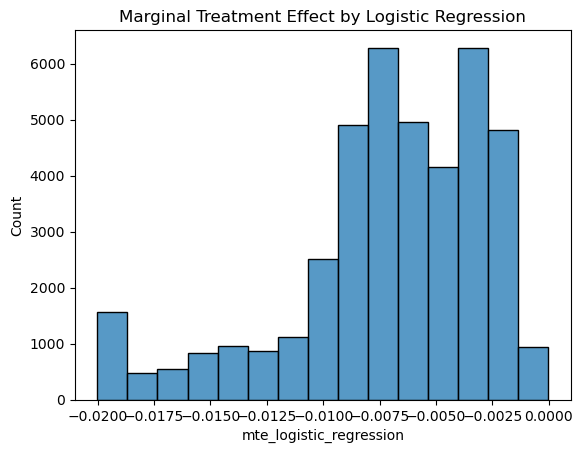

In [56]:
sns.histplot(df['mte_logistic_regression'], bins=15, kde=False)
plt.title('Marginal Treatment Effect by Logistic Regression')

In [57]:
df['y'].mean()

0.11265417111780131

## 1.2 Logistic Regression with Binned Treatment: Nonlinear Effects of Contact Frequency

To better capture how the number of contacts affects the likelihood of subscription, I decided to bin the campaign variable instead of treating it as a continuous feature. The main reason is that the effect of contacting a person once might be very different from contacting them 10 or 20 times. By creating bins such as 1, 2, 3, 4–5, 6–10, 11–20, and 21+, I can interpret the treatment effect more clearly at different levels of intensity. This also allows me to compare the impact across meaningful ranges instead of assuming the effect increases (or decreases) linearly with each additional contact. I used these bins in a logistic regression model to estimate the treatment effect of each group while controlling for other confounders like job, education, and month.

So overall, more follow-ups do not necessarily help — in fact, they might backfire after a certain point. This binning helped me see that clearly. Instead of assuming a straight line effect from the number of contacts, I can now see that the effect turns negative quite early and gets worse as contacts increase.

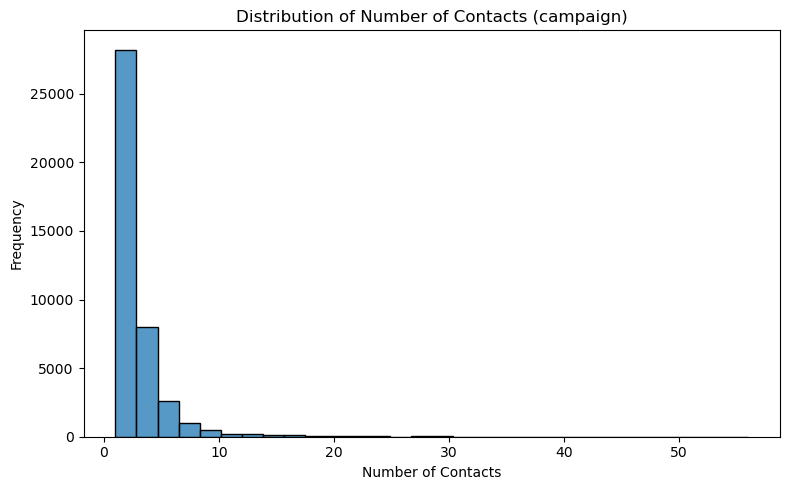

In [58]:
plt.figure(figsize=(8, 5))
sns.histplot(df['campaign'], bins=30, kde=False)
plt.title('Distribution of Number of Contacts (campaign)')
plt.xlabel('Number of Contacts')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

The results show a clear and consistent pattern: as the number of contacts increases, the likelihood of subscription decreases. Compared to the reference group (1 contact), the odds of subscribing are:

- **Slightly lower** for those contacted twice (coefficient = -0.0680, p = 0.092), although this effect is only marginally significant.
- **Not significantly** different for those contacted three times (coefficient = -0.0424, p = 0.420).
- **Significantly lower** for those contacted 4–5 times (coefficient = -0.2470, p < 0.001).
- **Further reduced** for 6–10 contacts (coefficient = -0.4957, p < 0.001).
- **Strongly negative** for 11–20 contacts (coefficient = -1.0080, p < 0.001).
- **Most negative** for 21 or more contacts (coefficient = -2.8218, p = 0.005).

hese findings suggest that repeated follow-ups beyond a few attempts may **backfire** and reduce the chance of a positive customer response. The effect appears to intensify as contact frequency increases, indicating potential fatigue or annoyance among customers.

Other control variables, such as job type, month of contact, and contact method, remain significant and consistent with prior results. Notably, contacting customers by **telephone** (vs. cellphone) again shows a large and significant negative effect on subscription likelihood.

In sum, this analysis highlights the importance of optimizing contact frequency in marketing campaigns. Over-contacting may not only be ineffective but also harmful to campaign success.

In [59]:
# Custom bin edges and labels
bins = [0, 1, 2, 3, 5, 10, 20, df['campaign'].max()]
labels = ['1', '2', '3', '4-5', '6-10', '11-20', '21+']

df['campaign_bin'] = pd.cut(df['campaign'], bins=bins, labels=labels, right=True)

formula = "y ~ C(campaign_bin) + C(job) + C(marital) + C(education) + C(default) + C(contact) + C(month) + C(day_of_week) + cons_price_idx"

model_binned = smf.logit(formula=formula, data=df).fit(maxiter=2000)

print(model_binned.summary())

Optimization terminated successfully.
         Current function value: 0.308761
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                41188
Model:                          Logit   Df Residuals:                    41144
Method:                           MLE   Df Model:                           43
Date:                Sun, 01 Jun 2025   Pseudo R-squ.:                  0.1229
Time:                        14:15:56   Log-Likelihood:                -12717.
converged:                       True   LL-Null:                       -14499.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              17.1088      3.542 

In [60]:
df['y'].mean()

0.11265417111780131

## 1.3 Logistic Regression: ``Campaign`` × ``Contact`` Interaction 

In earlier results, we saw that increasing the number of contacts (``campaign``) reduced the chances of a customer subscribing. But we also noticed that the contact method (telephone vs. cellular) had a strong effect on its own. This made me wonder:

- *Does the negative impact of repeated contact depend on how the customer was contacted*?
  
To answer this, I added an interaction term between ``campaign`` and ``contact`` to check whether the effect of contact frequency changes depending on the contact channel.

**Interpretation**

The main effect of campaign is negative and statistically significant (coefficient = **-0.0938**, p < 0.001), which means that increasing the number of contact attempts **reduces** the odds of subscription — consistent with previous results.

The main effect of ``contact = telephone`` is also **strongly negative** (coefficient = -1.0722, p < 0.001), showing that customers contacted by telephone are much less likely to subscribe compared to those contacted by cellular.


The key result is the **interaction term**: ``campaign × telephone`` has a **positive and statistically significant** coefficient (**+0.0425**, p = 0.022).

This means that although telephone contact is generally less effective, **the drop in subscription probability with more contacts is not as high** when using telephone compared to cellular. In other words, **the negative effect of campaign frequency is smaller when customers are contacted by telephone**.

This interaction suggests that **contact channel moderates how customers respond to repeated outreach**, and can be useful for targeting strategy in future campaigns.

In [61]:
formula = "y ~ campaign * C(contact) + C(job) + C(marital) + C(education) + C(default) + C(month) + C(day_of_week) + cons_price_idx"

model_contact = smf.logit(formula=formula, data=df).fit(maxiter=2000)

print(model_contact.summary())

Optimization terminated successfully.
         Current function value: 0.308694
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                41188
Model:                          Logit   Df Residuals:                    41148
Method:                           MLE   Df Model:                           39
Date:                Sun, 01 Jun 2025   Pseudo R-squ.:                  0.1231
Time:                        14:15:57   Log-Likelihood:                -12714.
converged:                       True   LL-Null:                       -14499.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              16.6522      3.539 

In [62]:
df['mte_logistic_regression_int'] = compute_mte_logit(model_contact, df, treatment_col='campaign', eps=1e-2 )

## 1.3 Slearner Approach: lightGBM

In this part of my analysis, I applied the S-learner method to estimate the causal effect of the number of contacts (``campaign``) on the probability of subscription. The S-learner is a flexible approach where we fit a single model (here **LightGBM**) that predicts the outcome based on both the features and the treatment. It’s called “S” because it uses a **single** model.

Mathematically, the idea is to estimate a function:
$$
\hat{f}(X,T) \approx \mathbb{E}[Y|X,T]
$$

where:
- $𝑋$ is the set of observed covariates (like job, education, etc.),
- $𝑇$ is the treatment (``campaign`` in my case),
- and $𝑌$ is the outcome (subscription).

Once the model is trained, the marginal treatment effect (MTE) for each observation is estimated by:
$$
\hat{\tau}(X) \approx \frac{ \hat{f}\left(  T_i+\epsilon,X_i \right)-\hat{f}\left(  T_i-\epsilon,X_i \right)}{2\epsilon}
$$

In [63]:
def preprocess_lgb_data(df, outcome_col='y', features=None, categorical_cols=None):

    # Default feature and categorical column settings
    if features is None:
        features = ['campaign', 'job', 'marital', 'education', 'default', 'contact', 'month', 'day_of_week', 'cons_price_idx']
    if categorical_cols is None:
        categorical_cols = ['job', 'marital', 'education', 'default', 'contact', 'month', 'day_of_week']

    df = df.copy()

    X = df[features].copy()
    y = df[outcome_col]

    for col in categorical_cols:
        X[col] = X[col].astype('category')

    return X, y

categorical_cols = ['job', 'marital', 'education', 'default', 'contact', 'month', 'day_of_week']
X, y = preprocess_lgb_data(df)


train_data = lgb.Dataset(X, label=y, categorical_feature=categorical_cols)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1
}

lgb_model = lgb.train(params, train_data, num_boost_round=100)

In [76]:
def estimate_mte_finite_diff(df, model, X, treatment_col='campaign', eps=0.5):

    X_plus = X.copy()
    X_minus = X.copy()
    
    # Add/subtract perturbation to treatment variable
    X_plus[treatment_col] += eps
    X_minus[treatment_col] -= eps

    mte = (model.predict(X_plus) - model.predict(X_minus)) / (2 * eps)

    return mte


In [77]:
df['mte_lightgbm'] = estimate_mte_finite_diff(df, lgb_model, X, treatment_col='campaign')


In [78]:
df['mte_lightgbm'].mean()

-0.0008759209049061448

## 1.3 Double Machine Learning

I used Double Machine Learning (DML) to estimate the causal effect of the number of contacts (``campaign``) on subscription. DML helps control for many background variables using machine learning in the first stage, and then estimates the treatment effect in a second stage. This method reduces bias and is powerful especially in complex datasets.

In [81]:
features = ['campaign', 'job', 'marital', 'education', 'default', 'contact', 'month', 'day_of_week', 'cons_price_idx']
treatment = 'campaign'
outcome = 'y'

X = df[features].copy()
T = df[treatment].values
Y = df[outcome].values

for col in X.select_dtypes(['category']).columns:
    X[col] = X[col].cat.codes

In [82]:
# Outcome model: binary (classification)
model_y = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1)

# Treatment model: continuous (regression)
model_t = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1)


In [83]:
est = LinearDML(
    model_y=model_y,
    model_t=model_t,
    discrete_treatment=False,      # T is modeled as a continuous variable
    linear_first_stages=False,
    random_state=42
)

est.fit(Y, T, X=X)

In [84]:
# Estimate marginal effect for each observation
df['mte_dml'] = est.effect(X)

# Optionally, compute average treatment effect
ate_dml = est.ate(X)
print("ATE (DML):", ate_dml)



ATE (DML): 0.005382829115488122


## 1.4 Evaluation of Approaches 

Cumulative gain is a performance evaluation metric used to assess how well a model ranks individuals based on their estimated treatment effect (like uplift or CATE). It plots the cumulative benefit (e.g., expected outcome gain) as we move down a sorted list of individuals from most to least likely to benefit. A steeper curve indicates better targeting—meaning the model effectively identifies those who respond most positively to the treatment. It's especially useful in causal inference and uplift modeling to compare different models' prioritization power.

In [87]:
# This code is adopted from https://github.com/RobertMelika/ML-S-T-DR-CATE-Resp-Care/blob/main/nb21.py
@curry
def elast(data, y, t):
    return (np.sum((data[t] - data[t].mean()) * (data[y] - data[y].mean())) /
            np.sum((data[t] - data[t].mean()) ** 2))


def elast_ci(df, y, t, z=1.96):
    n = df.shape[0]
    t_bar = df[t].mean()
    beta1 = elast(df, y, t)
    beta0 = df[y].mean() - beta1 * t_bar
    e = df[y] - (beta0 + beta1 * df[t])
    se = np.sqrt(((1 / (n - 2)) * np.sum(e ** 2)) / np.sum((df[t] - t_bar) ** 2))
    return np.array([beta1 - z * se, beta1 + z * se])


def cumulative_elast_curve_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]

    return np.array([elast_ci(ordered_df.head(rows), y, t) for rows in n_rows])


def cumulative_gain_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast_ci(ordered_df.head(rows), y, t) * (rows / size) for rows in n_rows])


def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), y, t) * (rows / size) for rows in n_rows])


def cumulative_gain_inv(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=True).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), y, t) * (rows / size) for rows in n_rows])

The figure shows the cumulative gain curves for four different models: Logistic Regression (red), Logistic Regression with Interaction (purple), LightGBM (green), and Double Machine Learning (orange). The x-axis shows the top-k percent of individuals ranked by their predicted treatment effect, and the y-axis shows the cumulative gain. This tells us how much benefit we get if we treat the top-ranked individuals first.

Among the models, **basic Logistic Regression** performs the best. Its curve stays well above the baseline and the other models, especially in the top percentiles. **Logistic Regression with interaction** also performs better than random and shows consistent gain, but slightly below its basic version. **LightGBM** performs worse than both logistic models, and **Double Machine Learning** performs the worst — its gain remains below all models and the baseline for much of the ranking. This means it struggles to correctly identify who benefits from the treatment.

In [88]:
def cumulative_gain_plot_ci(df, outcome, treatment, CATE_col, method_name,
                            Approach=None, Color='black', baseline=False, show=False, ci=True):

    steps = 100  # can be parameterized
    gain_values = cumulative_gain(df, CATE_col, y=outcome, t=treatment, steps=steps)
    percentiles = np.linspace(0, 100, len(gain_values))

    # Plot gain curve
    plt.plot(percentiles, gain_values, color=Color, label=method_name)

    # Confidence interval
    if ci:
        gain_ci = cumulative_gain_ci(df, CATE_col, y=outcome, t=treatment, steps=steps)
        lower, upper = gain_ci[:, 0], gain_ci[:, 1]
        plt.fill_between(percentiles, lower, upper, color=Color, alpha=0.2)

    # Baseline line
    if baseline:
        base = elast(df, outcome, treatment)
        plt.plot([0, 100], [0, base], linestyle='--', color='black', label='Baseline')

    # Final touches
    if show:
        title = 'Cumulative Gain with Confidence Interval' if Approach is None else f'Cumulative Gain on {Approach}'
        plt.title(title)
        plt.xlabel('Percentile (Top-k%)')
        plt.ylabel('Gain')
        plt.legend()
        plt.tight_layout()
        plt.show()


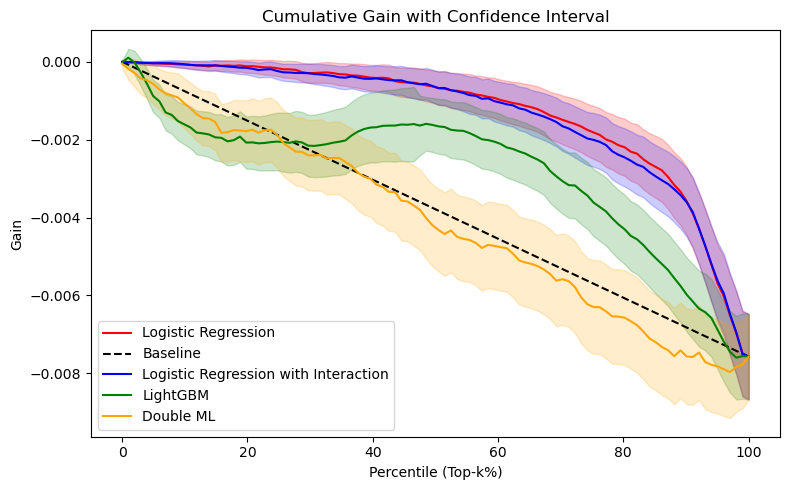

In [129]:
plt.figure(figsize=(8, 5))
cumulative_gain_plot_ci(df, "y", "campaign", "mte_logistic_regression", "Logistic Regression", Color="red", baseline=True)
cumulative_gain_plot_ci(df, "y", "campaign", "mte_logistic_regression_int", "Logistic Regression with Interaction", Color="blue")
cumulative_gain_plot_ci(df, "y", "campaign", "mte_lightgbm", "LightGBM", Color="green")
cumulative_gain_plot_ci(df, "y", "campaign", "mte_dml", "Double ML", Color="orange", show=True)


# 2. Does increasing the duration of a client contact (duration) cause a higher probability of subscribing to a term deposit?

In this part of the analysis, I study whether increasing the duration of contact with a client causes a higher chance of subscription to a term deposit. The key question is whether **increasing the duration itself leads to a higher probability of subscribing**, holding other factors constant.

To answer this, I treat **call ``duration``** as the treatment variable and **subscription** as the binary outcome. I control for potential confounders such as job type, marital status, education, default history, contact method, the month and day of the week of the call, and consumer price index. These variables are chosen to adjust for background characteristics that might influence both the duration of the call and the client’s likelihood of subscribing. By doing so, I aim to isolate the causal effect of duration itself.

In [184]:
# Converting the duration of calls to minutes
df['duration'] = df['duration'] / 60

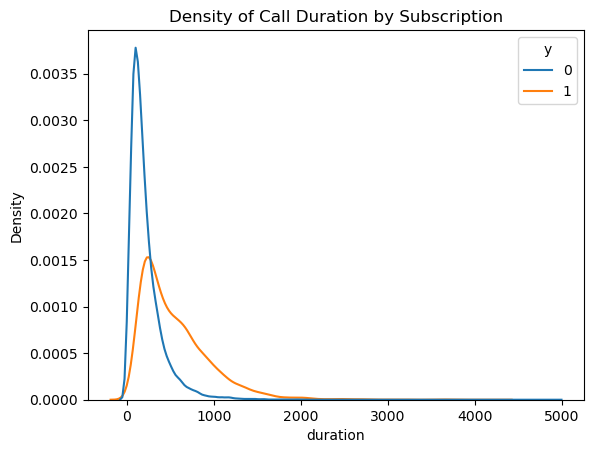

In [143]:
sns.kdeplot(data=df, x='duration', hue='y', common_norm=False)
plt.title("Density of Call Duration by Subscription")
plt.show()


In [140]:
df.groupby('y')['duration'].mean()


y
0    220.844807
1    553.191164
Name: duration, dtype: float64

## 2.1 Logistic Regression

This logistic regression model estimates the effect of **call duration** (in minutes) on the probability that a customer subscribes (``y``), controlling for demographic and campaign-related covariates.

**Key Findings:**
- The coefficient for duration is **0.2556**, and it is highly statistically significant (p < 0.001).
- Interpreted as a log-odds increase, this means that **each additional minute** of contact is associated with an increase in the log-odds of subscription by 0.2556.
$$
\text{Odd ratio} = e^{0.2556} \approx 1.291
$$
Thus, every **1-minute increase in call duration raises the odds of subscription by approximately 29.1%**, holding all other variables constant.

This effect confirms that **longer calls are strongly associated with a higher likelihood of customer conversion**.

In [164]:
formula = (
    "y ~ duration + C(job) + C(marital) + C(education) + "
    "C(default) + C(contact) + C(month) + C(day_of_week) + cons_price_idx"
)

model = smf.logit(formula=formula, data=df).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.244563
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                41188
Model:                          Logit   Df Residuals:                    41149
Method:                           MLE   Df Model:                           38
Date:                Sun, 01 Jun 2025   Pseudo R-squ.:                  0.3053
Time:                        01:26:46   Log-Likelihood:                -10073.
converged:                       True   LL-Null:                       -14499.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              31.7573      3.873 

In [165]:
df['mte_logistic_regression'] = compute_mte_logit(model, df, treatment_col='duration', eps=1e-2 )


## 2.2 Slearner: LightGBM

Now, similar to Question 1, I use Slearner with LightGBM as the learner for this task.

In [176]:
features = ['duration', 'job', 'marital', 'education', 'default', 
            'contact', 'month', 'day_of_week', 'cons_price_idx']
categorical_cols = ['job', 'marital', 'education', 'default', 
                    'contact', 'month', 'day_of_week']

X, y = preprocess_lgb_data(df, features=features, categorical_cols=categorical_cols)
# LightGBM Dataset
train_data = lgb.Dataset(X, label=y, categorical_feature=categorical_cols)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'seed': 42
}

lgb_model = lgb.train(params, train_data, num_boost_round=100)

In [177]:
df['mte_lightgbm'] = estimate_mte_finite_diff(df, lgb_model, X, treatment_col='duration')


## 2.3 Double Machine Learning


In [169]:
# Set variables: 'duration' is excluded because it is the treatment variable. 
features = ['job', 'marital', 'education', 'default', 'contact', 
            'month', 'day_of_week', 'cons_price_idx']  
treatment = 'duration'
outcome = 'y'

X = df[features].copy()
T = df[treatment].values
Y = df[outcome].values

# Encode categorical features as integers
for col in X.select_dtypes(['category']).columns:
    X[col] = X[col].cat.codes

# Models for outcome and treatment
model_y = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1)
model_t = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1)

# LinearDML estimator: I use linear model to predict the subscription probability
est = LinearDML(
    model_y=model_y,
    model_t=model_t,
    discrete_treatment=False,
    linear_first_stages=False,
    random_state=42
)

est.fit(Y, T, X=X)

In [170]:
# MTE estimatin
df['mte_dml'] = est.effect(X)

# ATE
ate_dml = est.ate(X)
print("ATE (DML):", ate_dml)

ATE (DML): 0.02816474028150411


## 2.4 Evaluation of Approaches

The figure displays **cumulative gain** curves for three models — **Logistic Regression** (red), **LightGBM** (blue), and **Double ML** (green) — along with a **baseline** (black dashed line) which represents random treatment assignment.

- **LightGBM** (blue) performs the best across nearly all percentiles. Its curve is consistently above both Logistic Regression and the baseline, especially in the top **20–70%** range. This suggests that LightGBM is better at **ranking individuals** by their treatment effect and **identifying who benefits the most from increased duration**.

- **Double ML** is almost as good as LightGBM in this task.

- **Logistic Regression**, while simple and interpretable, may be too limited for this task due to its linear nature.

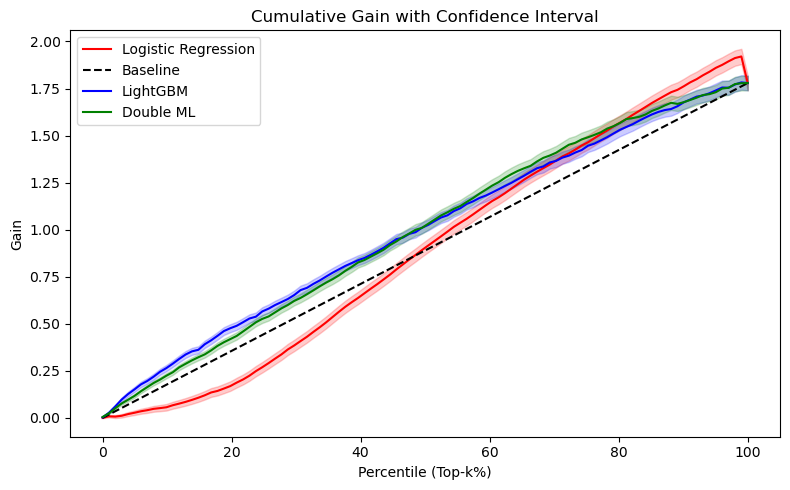

In [190]:
plt.figure(figsize=(8, 5))
cumulative_gain_plot_ci(df, "y", "duration", "mte_logistic_regression", "Logistic Regression", Color="red", baseline=True)
cumulative_gain_plot_ci(df, "y", "duration", "mte_lightgbm", "LightGBM", Color="blue", baseline=False)
cumulative_gain_plot_ci(df, "y", "duration", "mte_dml", "Double ML", Color="green", baseline=False, show=True)
